In [148]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from gtda.pipeline import Pipeline
from gtda.time_series import Resampler
from gtda.diagrams import PersistenceEntropy, Scaler, HeatKernel, BettiCurve
import numpy as np
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters, TakensEmbedding
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer

We start by analyzing the public data set and looking at the normal operations time series, to set a benchmark for the analysis of well events (abnormal operations). 

In [111]:
sample_data_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/WELL-00005_20170331160000.csv")

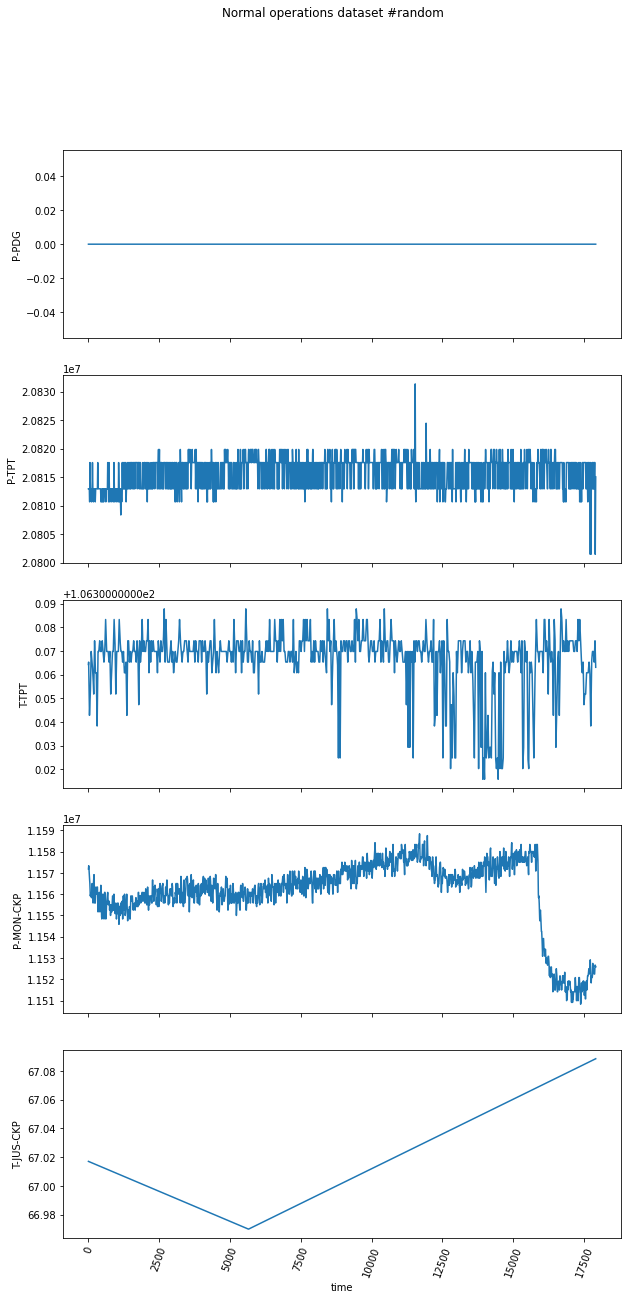

In [112]:
fig, ts = plt.subplots(5,figsize=(10,20),sharex = True)

fig.suptitle('Normal operations dataset #random')
ts[4].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(sample_data_df.index, sample_data_df["P-PDG"])
ts[1].plot(sample_data_df.index, sample_data_df["P-TPT"])
ts[2].plot(sample_data_df.index, sample_data_df["T-TPT"])
ts[3].plot(sample_data_df.index, sample_data_df["P-MON-CKP"])
ts[4].plot(sample_data_df.index, sample_data_df["T-JUS-CKP"])

It looks like the most information is stored in the TPT (bottomhole) pressure and temperature time series. We start from the Pressure. 

## Analysis of Normal Operations: P- TPT

In [113]:
def find_shortest_file(path, label):
    tmp = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        tmp.append(len(data_df[label]))
    return min(tmp)

In [114]:
def read_files(path, label, limit):
    data = []
    os.chdir(path)
    i = 0
    for file in os.listdir():
        data_df = pd.read_csv(file)
        # fill NaN with an interpolated value
        data_df = data_df.interpolate()
        period = int(len(data_df)/limit)
        periodicSampler = Resampler(period=period)
        print(i,file)
        # resample the files to that all of them are the same length (in entries)
        # NOTE: timestamps are omitted and timesteps are going to be different for each resampled time series!
        index_sampled, signal_sampled = periodicSampler.fit_transform_resample(data_df.index, data_df[label])
        data.append(signal_sampled)
        i += 1
    data_T = list(map(list, zip(*data)))
    data = np.array(data_T)
    df = pd.DataFrame.from_records(data_T)
    return data.T, df

In [115]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/", "P-TPT")

7010

The time series are pretty large, so we rescale them to a uniform resampling at 3000 points, to be managenable for computing their embedding and persistence diagrams. We keep 3000 points for displying point clouds and 1000 for diagrams.

In [116]:
normal_signals, normal_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/", "P-TPT",3000)

0 WELL-00002_20170625220127.csv
1 WELL-00008_20170611080445.csv
2 WELL-00002_20170810020026.csv
3 WELL-00007_20170801180000.csv
4 WELL-00002_20170612110022.csv
5 WELL-00001_20170527160000.csv
6 WELL-00001_20170527060000.csv
7 WELL-00005_20170812170000.csv
8 WELL-00008_20170703060123.csv
9 WELL-00006_20170828140031.csv
10 WELL-00006_20170209000114.csv
11 WELL-00008_20170612140047.csv
12 WELL-00005_20170814200000.csv
13 WELL-00002_20170623150127.csv
14 WELL-00002_20170620140116.csv
15 WELL-00002_20170613070011.csv
16 WELL-00002_20170621180032.csv
17 WELL-00005_20170815050000.csv
18 WELL-00002_20170621030054.csv
19 WELL-00006_20170207080124.csv
20 WELL-00002_20170218210134.csv
21 WELL-00002_20170214220322.csv
22 WELL-00006_20170508090031.csv
23 WELL-00002_20170621080422.csv
24 WELL-00002_20170625170232.csv
25 WELL-00008_20170612190111.csv
26 WELL-00001_20170219070031.csv
27 WELL-00002_20170210230203.csv
28 WELL-00008_20170702050135.csv
29 WELL-00002_20170804210000.csv
30 WELL-00005_201708

253 WELL-00002_20170618070105.csv
254 WELL-00006_20170817080000.csv
255 WELL-00006_20170817180000.csv
256 WELL-00002_20170617220127.csv
257 WELL-00006_20170819050000.csv
258 WELL-00006_20170819150000.csv
259 WELL-00006_20170209100207.csv
260 WELL-00001_20170425040207.csv
261 WELL-00001_20170201020207.csv
262 WELL-00002_20131211230015.csv
263 WELL-00006_20170224020000.csv
264 WELL-00006_20170826220114.csv
265 WELL-00001_20170823150000.csv
266 WELL-00001_20170823050000.csv
267 WELL-00001_20170523120000.csv
268 WELL-00001_20170218060218.csv
269 WELL-00005_20170813200000.csv
270 WELL-00002_20170625070243.csv
271 WELL-00003_20170514010000.csv
272 WELL-00005_20170815170000.csv
273 WELL-00003_20170514110000.csv
274 WELL-00006_20170507030249.csv
275 WELL-00008_20170611130123.csv
276 WELL-00006_20170822080000.csv
277 WELL-00001_20170825220000.csv
278 WELL-00006_20170822180000.csv
279 WELL-00006_20170820160000.csv
280 WELL-00004_20140807060141.csv
281 WELL-00006_20170820060000.csv
282 WELL-00008

502 WELL-00005_20170816230000.csv
503 WELL-00002_20170219120152.csv
504 WELL-00002_20170618120600.csv
505 WELL-00008_20170611230123.csv
506 WELL-00005_20170830210000.csv
507 WELL-00002_20170809160026.csv
508 WELL-00006_20170509150042.csv
509 WELL-00006_20170222050000.csv
510 WELL-00006_20170222150000.csv
511 WELL-00002_20170621130116.csv
512 WELL-00001_20170825120000.csv
513 WELL-00001_20170825020000.csv
514 WELL-00006_20170827080114.csv
515 WELL-00006_20170821120000.csv
516 WELL-00001_20170528220000.csv
517 WELL-00006_20170821020000.csv
518 WELL-00002_20170310030146.csv
519 WELL-00008_20170819120210.csv
520 WELL-00002_20170626180138.csv
521 WELL-00002_20131212070005.csv
522 WELL-00006_20170826070135.csv
523 WELL-00006_20170223210000.csv
524 WELL-00002_20170218010237.csv
525 WELL-00002_20170806230000.csv
526 WELL-00008_20170914020321.csv
527 WELL-00005_20170516050046.csv
528 WELL-00002_20170611050011.csv
529 WELL-00001_20170522160000.csv
530 WELL-00001_20170522060000.csv
531 WELL-00002

In [117]:
normal_df

0           1          2           3          4           5    \
0     8698015.0  13987430.0  8648771.0  13036680.0  8055306.0  14184150.0   
1     8698015.0  13987380.0  8648508.0  13036660.0  8054475.0  14184150.0   
2     8698015.0  13987330.0  8648246.0  13036650.0  8053644.0  14184150.0   
3     8698015.0  13987290.0  8647984.0  13036630.0  8052812.0  14184150.0   
4     8698015.0  13987240.0  8647721.0  13036620.0  8051981.0  14184150.0   
...         ...         ...        ...         ...        ...         ...   
3018  8421824.0  13987690.0  8553652.0  13038030.0  8690605.0  14226720.0   
3019  8422378.0  13986730.0  8551839.0  13038090.0  8689180.0  14227280.0   
3020  8422932.0  13985770.0  8550025.0  13038150.0  8687755.0  14227840.0   
3021  8423486.0  13985090.0  8548212.0  13038200.0  8686330.0  14228390.0   
3022  8424040.0  13985520.0  8546397.0  13038260.0  8684904.0  14228950.0   

             6           7           8           9    ...        587  \
0     14221150.0  20932460.0  13385940.0  21146550.0  ...  8706865.0   
1     14221710.0  20930170.0  13386170.0  21146550.0  ...  8706683.0   
2     14222260.0  20927870.0  13386410.0  21146550.0  ...  8706503.0   
3     14222820.0  20930170.0  13386640.0  21146550.0  ...  8706321.0   
4     14223380.0  20932460.0  13386530.0  21146550.0  ...  8706139.0   
...          ...         ...         ...         ...  ...        ...   
3018  14259950.0  20920970.0  13383880.0  21146550.0  ...  8458620.0   
3019  14259680.0  20923270.0  13383740.0  21146550.0  ...  8458620.0   
3020  14259410.0  20909480.0  13383590.0  21146550.0  ...  8458620.0   
3021  14259130.0  20910630.0  13383450.0  21146550.0  ...  8458620.0   
3022  14258860.0  20911780.0  13383310.0  21146550.0  ...  8458620.0   

            588         589         590         591         592         593  \
0     8550073.0  13849550.0  20997960.0  20811280.0  10005130.0  20934760.0   
1     8550598.0  13849760.0  20998540.0  20810660.0  10005660.0  20930170.0   
2     8551123.0  13849970.0  20999110.0  20810660.0  10006180.0  20916380.0   
3     8551648.0  13850190.0  20996810.0  20810870.0  10006710.0  20923270.0   
4     8552173.0  13849870.0  20994520.0  20811910.0  10007230.0  20927870.0   
...         ...         ...         ...         ...         ...         ...   
3018  8554821.0  13849160.0  20997580.0  20817550.0  10014690.0  20886500.0   
3019  8554267.0  13848840.0  20997770.0  20817550.0  10014690.0  20881900.0   
3020  8553713.0  13849120.0  20997960.0  20814420.0  10014690.0  20868110.0   
3021  8553159.0  13849550.0  20998160.0  20811280.0  10014690.0  20873280.0   
3022  8552605.0  13849970.0  20998350.0  20811490.0  10014690.0  20877310.0   

            594        595        596  
0     8179326.0  8499783.0  8101855.0  
1     8179326.0  8500115.0  8100192.0  
2     8179326.0  8500448.0  8098530.0  
3     8179326.0  8500780.0  8096867.0  
4     8179326.0  8501112.0  8095205.0  
...         ...        ...        ...  
3018  7966172.0  8517471.0  8849312.0  
3019  7965405.0  8518468.0  8848913.0  
3020  7964638.0  8518468.0  8848515.0  
3021  7963870.0  8518468.0  8848116.0  
3022  7963103.0  8518468.0  8847717.0  

[3023 rows x 597 columns]

Some of these time series are not stationary. I convert Pa to Bar and remove those with a drift higher than 5 Bar.

In [118]:
naughty_list = []
for timeserie in normal_df:
    if abs(normal_df[timeserie].iloc[-1]-normal_df[timeserie].iloc[0]) > 500000:
        print(timeserie, normal_df[timeserie].iloc[-1], normal_df[timeserie].iloc[0])
        naughty_list.append(timeserie)

4 8684904.0 8055306.0
41 8664765.0 7644843.0
54 8699012.0 8079578.0
143 8741638.0 8058631.0
152 8409943.0 7875877.0
305 8604584.0 9268692.0
312 8717964.0 7850483.0
322 8632957.0 8063186.0
375 8861601.0 8145411.0
431 8968408.0 8178993.0
441 9075394.0 7947331.0
446 9198749.0 7461141.0
455 8837662.0 8037888.0
478 8631278.0 8059628.0
551 8266615.0 7580839.0
596 8847717.0 8101855.0


In [119]:
PatoBar = 1/100000
normal_df = normal_df.apply(lambda x: x*PatoBar) 
normal_signals = normal_signals * PatoBar

Removing from the steady state dataframe, those timeseries that have a deviation of more than 5 Bar

In [159]:
normal_df = normal_df.drop(naughty_list, axis=1)
normal_df

0         1         2         3         5         6         7    \
0     86.98015  139.8743  86.48771  130.3668  141.8415  142.2115  209.3246   
1     86.98015  139.8738  86.48508  130.3666  141.8415  142.2171  209.3017   
2     86.98015  139.8733  86.48246  130.3665  141.8415  142.2226  209.2787   
3     86.98015  139.8729  86.47984  130.3663  141.8415  142.2282  209.3017   
4     86.98015  139.8724  86.47721  130.3662  141.8415  142.2338  209.3246   
...        ...       ...       ...       ...       ...       ...       ...   
3018  84.21824  139.8769  85.53652  130.3803  142.2672  142.5995  209.2097   
3019  84.22378  139.8673  85.51839  130.3809  142.2728  142.5968  209.2327   
3020  84.22932  139.8577  85.50025  130.3815  142.2784  142.5941  209.0948   
3021  84.23486  139.8509  85.48212  130.3820  142.2839  142.5913  209.1063   
3022  84.24040  139.8552  85.46397  130.3826  142.2895  142.5886  209.1178   

           8         9         10   ...       586       587       588  \
0     133.8594  211.4655  182.3391  ...  98.92381  87.06865  85.50073   
1     133.8617  211.4655  182.3391  ...  98.92764  87.06683  85.50598   
2     133.8641  211.4655  182.3391  ...  98.93147  87.06503  85.51123   
3     133.8664  211.4655  182.3391  ...  98.93531  87.06321  85.51648   
4     133.8653  211.4655  182.3391  ...  98.93915  87.06139  85.52173   
...        ...       ...       ...  ...       ...       ...       ...   
3018  133.8388  211.4655  182.3391  ...  98.87730  84.58620  85.54821   
3019  133.8374  211.4655  182.3391  ...  98.87461  84.58620  85.54267   
3020  133.8359  211.4655  182.3391  ...  98.87192  84.58620  85.53713   
3021  133.8345  211.4655  182.3391  ...  98.86923  84.58620  85.53159   
3022  133.8331  211.4655  182.3391  ...  98.86655  84.58620  85.52605   

           589       590       591       592       593       594       595  
0     138.4955  209.9796  208.1128  100.0513  209.3476  81.79326  84.99783  
1     138.4976  209.9854  208.1066  100.0566  209.3017  81.79326  85.00115  
2     138.4997  209.9911  208.1066  100.0618  209.1638  81.79326  85.00448  
3     138.5019  209.9681  208.1087  100.0671  209.2327  81.79326  85.00780  
4     138.4987  209.9452  208.1191  100.0723  209.2787  81.79326  85.01112  
...        ...       ...       ...       ...       ...       ...       ...  
3018  138.4916  209.9758  208.1755  100.1469  208.8650  79.66172  85.17471  
3019  138.4884  209.9777  208.1755  100.1469  208.8190  79.65405  85.18468  
3020  138.4912  209.9796  208.1442  100.1469  208.6811  79.64638  85.18468  
3021  138.4955  209.9816  208.1128  100.1469  208.7328  79.63870  85.18468  
3022  138.4997  209.9835  208.1149  100.1469  208.7731  79.63103  85.18468  

[3023 rows x 581 columns]

In [121]:
tmp = normal_df[normal_df.index % 3 == 0]  # Excludes every 3rd row starting from 0
tmp

0         1         2         3         5         6         7    \
0     86.98015  139.8743  86.48771  130.3668  141.8415  142.2115  209.3246   
3     86.98015  139.8729  86.47984  130.3663  141.8415  142.2282  209.3017   
6     86.98015  139.8715  86.47195  130.3659  141.8415  142.2405  209.2787   
9     86.98015  139.8701  86.46408  130.3654  141.8415  142.2405  209.2902   
12    86.98015  139.8688  86.45621  130.3615  141.8415  142.2405  209.2902   
...        ...       ...       ...       ...       ...       ...       ...   
3009  84.15894  139.8535  85.69975  130.3789  142.3091  142.6238  209.1293   
3012  84.18388  139.8641  85.64534  130.3768  142.2601  142.6157  209.1178   
3015  84.20161  139.8833  85.59093  130.3785  142.2505  142.6076  209.1638   
3018  84.21824  139.8769  85.53652  130.3803  142.2672  142.5995  209.2097   
3021  84.23486  139.8509  85.48212  130.3820  142.2839  142.5913  209.1063   

           8         9         10   ...       586       587       588  \
0     133.8594  211.4655  182.3391  ...  98.92381  87.06865  85.50073   
3     133.8664  211.4655  182.3391  ...  98.93531  87.06321  85.51648   
6     133.8585  211.4655  182.3391  ...  98.94682  87.05777  85.53223   
9     133.8483  211.4655  182.3391  ...  98.94989  87.05233  85.54798   
12    133.8381  211.4655  182.3391  ...  98.94989  87.04689  85.56373   
...        ...       ...       ...  ...       ...       ...       ...   
3009  133.8515  211.4655  182.3391  ...  98.90150  84.61612  85.60529   
3012  133.8473  211.4655  182.3391  ...  98.89343  84.58620  85.58146   
3015  133.8430  211.4655  182.3391  ...  98.88536  84.58620  85.56483   
3018  133.8388  211.4655  182.3391  ...  98.87730  84.58620  85.54821   
3021  133.8345  211.4655  182.3391  ...  98.86923  84.58620  85.53159   

           589       590       591       592       593       594       595  
0     138.4955  209.9796  208.1128  100.0513  209.3476  81.79326  84.99783  
3     138.5019  209.9681  208.1087  100.0671  209.2327  81.79326  85.00780  
6     138.4923  209.9758  208.1191  100.0828  209.2557  81.79326  85.01778  
9     138.4861  209.9682  208.1254  100.0986  209.1638  81.79326  85.02775  
12    138.4829  210.0371  208.1295  100.1143  209.3017  81.79326  85.03773  
...        ...       ...       ...       ...       ...       ...       ...  
3009  138.4957  209.9682  208.1191  100.1469  208.6897  79.73078  84.98519  
3012  138.4989  209.9911  208.1630  100.1469  208.6581  79.70776  84.98519  
3015  138.5012  209.9701  208.1379  100.1469  208.7271  79.68474  85.02509  
3018  138.4916  209.9758  208.1755  100.1469  208.8650  79.66172  85.17471  
3021  138.4955  209.9816  208.1128  100.1469  208.7328  79.63870  85.18468  

[1008 rows x 581 columns]

freq units: 3.307972E-05 Hz


<AxesSubplot:xlabel='BHP', ylabel='count'>

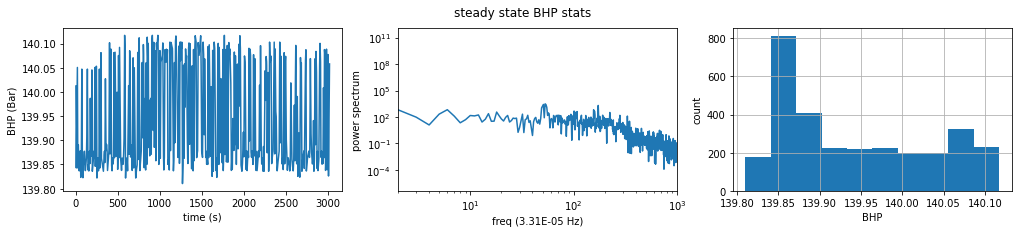

In [157]:
fig_ss_analysis, data = plt.subplots(1, 3, figsize=(17, 3))

from random import gauss
from random import seed
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot

freq_units = 0.1/len(normal_df[25])
print('freq units: %(units)4E Hz' %{"units":(freq_units)})

fig_ss_analysis.suptitle('steady state BHP stats')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('BHP (Bar)')
data[1].set_xlabel('freq (%(units).2E Hz)' %{"units":(freq_units)})
data[1].set_ylabel('power spectrum')
data[2].set_xlabel('BHP')
data[2].set_ylabel('count')

data[1].set_xlim(2,1000)
data[1].set_yscale('log')
data[1].set_xscale('log')

ss_BHP = normal_df[25]

fft_ss = np.fft.rfft(ss_BHP)
fft_ss_abs = np.abs(fft_ss)
power_spectrum_ss = np.square(fft_ss_abs)


data[0].plot(ss_BHP)
data[1].plot(power_spectrum_ss)
ss_BHP.hist()

Let's start by embedding each normal operation time series to their optimal parameters. This is probably an overkill, but at least we'll see if there is any clear trend in the topological indicators.

In [122]:
def batch_analyzer(input_df, stride, max_embedding_dimension, max_time_delay):
    max_time_delay = int(max_time_delay)
    max_embedding_dimension = int(max_embedding_dimension)
    homology_dimensions = (0, 1)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
    pca = PCA(n_components=3)
    PE_signal = PersistenceEntropy()
    PE_norm = PersistenceEntropy(normalize=True)

    entropies = []
    norm_entropies = []
    diagrams = []
    point_clouds_pca = []
    i = 0
    
    print('max time delay:',max_time_delay, 'max dim:',max_embedding_dimension)
    
    for timeserie in input_df:
        
        i += 1
        optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
            input_df[timeserie], max_time_delay, max_embedding_dimension, stride=stride
            )
        if optimal_embedding_dimension < 3:
            optimal_embedding_dimension = 3
            
        print('analyzing nr.',i, 'progress:',int(100*i/len(input_df.columns)),'%', 'dim',optimal_embedding_dimension,'delay', optimal_time_delay)

        embedder = SingleTakensEmbedding(
            parameters_type="fixed", n_jobs=6, time_delay=optimal_time_delay, dimension=optimal_embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(input_df[timeserie])
        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        X_diagram = VRP.fit_transform(y_signal_embedded_reshaped)
        features = PE_signal.fit_transform(X_diagram)
        features_norm = PE_norm.fit_transform(X_diagram)
        if optimal_embedding_dimension > 3:
            point_clouds_pca.append(y_signal_embedded_pca)
        else:
            point_clouds_pca.append(y_signal_embedded)
        entropies.append(features)
        norm_entropies.append(features_norm)
        diagrams.append(X_diagram)
    return(point_clouds_pca, diagrams, entropies, norm_entropies)

In [123]:
normal_point_clouds_pca, normal_diagrams, normal_entropies, normal_norm_entropies = batch_analyzer(normal_df, 3, 13, 90)


max time delay: 90 max dim: 13
analyzing nr. 1 progress: 0 % dim 3 delay 87
analyzing nr. 2 progress: 0 % dim 8 delay 29
analyzing nr. 3 progress: 0 % dim 9 delay 88
analyzing nr. 4 progress: 0 % dim 8 delay 87
analyzing nr. 5 progress: 0 % dim 9 delay 87
analyzing nr. 6 progress: 1 % dim 9 delay 90
analyzing nr. 7 progress: 1 % dim 9 delay 75
analyzing nr. 8 progress: 1 % dim 6 delay 46
analyzing nr. 9 progress: 1 % dim 3 delay 90
analyzing nr. 10 progress: 1 % dim 9 delay 90
analyzing nr. 11 progress: 1 % dim 6 delay 29
analyzing nr. 12 progress: 2 % dim 7 delay 81
analyzing nr. 13 progress: 2 % dim 6 delay 86
analyzing nr. 14 progress: 2 % dim 4 delay 89
analyzing nr. 15 progress: 2 % dim 5 delay 90
analyzing nr. 16 progress: 2 % dim 3 delay 81
analyzing nr. 17 progress: 2 % dim 6 delay 51
analyzing nr. 18 progress: 3 % dim 9 delay 89
analyzing nr. 19 progress: 3 % dim 7 delay 90
analyzing nr. 20 progress: 3 % dim 9 delay 89
analyzing nr. 21 progress: 3 % dim 5 delay 90
analyzing nr

analyzing nr. 175 progress: 30 % dim 9 delay 90
analyzing nr. 176 progress: 30 % dim 5 delay 90
analyzing nr. 177 progress: 30 % dim 7 delay 26
analyzing nr. 178 progress: 30 % dim 9 delay 90
analyzing nr. 179 progress: 30 % dim 6 delay 41
analyzing nr. 180 progress: 30 % dim 6 delay 64
analyzing nr. 181 progress: 31 % dim 7 delay 83
analyzing nr. 182 progress: 31 % dim 9 delay 88
analyzing nr. 183 progress: 31 % dim 6 delay 89
analyzing nr. 184 progress: 31 % dim 9 delay 88
analyzing nr. 185 progress: 31 % dim 10 delay 62
analyzing nr. 186 progress: 32 % dim 6 delay 84
analyzing nr. 187 progress: 32 % dim 7 delay 82
analyzing nr. 188 progress: 32 % dim 7 delay 89
analyzing nr. 189 progress: 32 % dim 7 delay 88
analyzing nr. 190 progress: 32 % dim 5 delay 41
analyzing nr. 191 progress: 32 % dim 8 delay 75
analyzing nr. 192 progress: 33 % dim 6 delay 49
analyzing nr. 193 progress: 33 % dim 7 delay 90
analyzing nr. 194 progress: 33 % dim 7 delay 90
analyzing nr. 195 progress: 33 % dim 9 

analyzing nr. 346 progress: 59 % dim 9 delay 90
analyzing nr. 347 progress: 59 % dim 7 delay 90
analyzing nr. 348 progress: 59 % dim 6 delay 49
analyzing nr. 349 progress: 60 % dim 12 delay 50
analyzing nr. 350 progress: 60 % dim 10 delay 27
analyzing nr. 351 progress: 60 % dim 6 delay 30
analyzing nr. 352 progress: 60 % dim 9 delay 90
analyzing nr. 353 progress: 60 % dim 3 delay 87
analyzing nr. 354 progress: 60 % dim 7 delay 90
analyzing nr. 355 progress: 61 % dim 7 delay 84
analyzing nr. 356 progress: 61 % dim 3 delay 90
analyzing nr. 357 progress: 61 % dim 9 delay 88
analyzing nr. 358 progress: 61 % dim 9 delay 90
analyzing nr. 359 progress: 61 % dim 10 delay 83
analyzing nr. 360 progress: 61 % dim 9 delay 89
analyzing nr. 361 progress: 62 % dim 8 delay 90
analyzing nr. 362 progress: 62 % dim 3 delay 90
analyzing nr. 363 progress: 62 % dim 8 delay 90
analyzing nr. 364 progress: 62 % dim 3 delay 90
analyzing nr. 365 progress: 62 % dim 4 delay 90
analyzing nr. 366 progress: 62 % dim 

analyzing nr. 517 progress: 88 % dim 9 delay 89
analyzing nr. 518 progress: 89 % dim 3 delay 90
analyzing nr. 519 progress: 89 % dim 9 delay 90
analyzing nr. 520 progress: 89 % dim 7 delay 65
analyzing nr. 521 progress: 89 % dim 9 delay 90
analyzing nr. 522 progress: 89 % dim 9 delay 90
analyzing nr. 523 progress: 90 % dim 9 delay 90
analyzing nr. 524 progress: 90 % dim 9 delay 90
analyzing nr. 525 progress: 90 % dim 6 delay 45
analyzing nr. 526 progress: 90 % dim 9 delay 90
analyzing nr. 527 progress: 90 % dim 8 delay 90
analyzing nr. 528 progress: 90 % dim 9 delay 90
analyzing nr. 529 progress: 91 % dim 9 delay 90
analyzing nr. 530 progress: 91 % dim 10 delay 86
analyzing nr. 531 progress: 91 % dim 9 delay 88
analyzing nr. 532 progress: 91 % dim 10 delay 82
analyzing nr. 533 progress: 91 % dim 10 delay 86
analyzing nr. 534 progress: 91 % dim 5 delay 79
analyzing nr. 535 progress: 92 % dim 6 delay 90
analyzing nr. 536 progress: 92 % dim 6 delay 87
analyzing nr. 537 progress: 92 % dim 

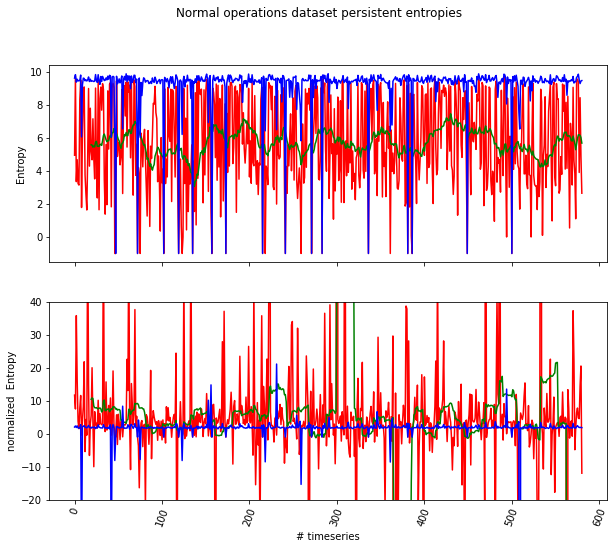

In [124]:
tmp_entropies = normal_entropies
Entropy_H0 = []
Entropy_H1 = []
tmp_normalized = normal_norm_entropies
Entropy_H0_norm = []
Entropy_H1_norm = []

for item in tmp_entropies:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

for item in tmp_normalized:
    Entropy_H0_norm.append(item[0][0])
    Entropy_H1_norm.append(item[0][1])
    
Entropy_H1_series = pd.Series(Entropy_H1)
Entropy_H1_norm_series = pd.Series(Entropy_H1_norm)

entropies, ts = plt.subplots(2,figsize=(10,8),sharex = True)

entropies.suptitle('Normal operations dataset persistent entropies')
ts[1].set_xlabel("# timeseries")
ts[0].set_ylabel('Entropy')
ts[1].set_ylabel('normalized  Entropy')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(Entropy_H1,'r-')
ts[0].plot(Entropy_H1_series.rolling(20).mean(), 'g-')
ts[0].plot(Entropy_H0,'b-')

ts[1].set_ylim([-20,40])
ts[1].plot(Entropy_H1_norm,'r-')
ts[1].plot(Entropy_H1_norm_series.rolling(20).mean(), 'g-')
ts[1].plot(Entropy_H0_norm,'b-')

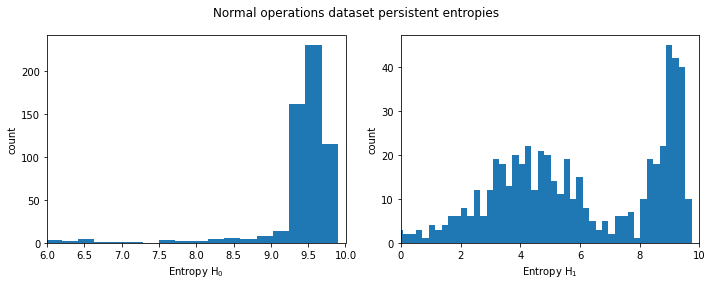

In [211]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))
stats_entropy.suptitle('Normal operations dataset persistent entropies')

data[0].set_xlabel('Entropy H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Entropy H$_1$")
data[1].set_ylabel('count')

data[0].set_xlim(6,10)
data[1].set_xlim(0,10)
data[0].hist(Entropy_H0, bins=50)
data[1].hist(Entropy_H1, bins=50)

plt.tight_layout()

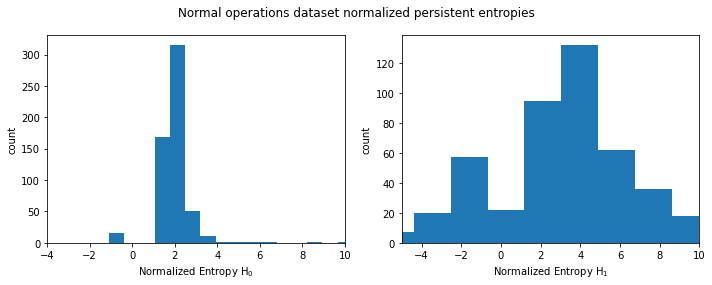

In [226]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))

stats_entropy.suptitle('Normal operations dataset normalized persistent entropies')

data[0].set_xlabel('Normalized Entropy H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Normalized Entropy H$_1$")
data[1].set_ylabel('count')

data[0].set_xlim(-4,10)
data[1].set_xlim(-5,10)
data[0].hist(Entropy_H0_norm, bins=500)
data[1].hist(Entropy_H1_norm, bins=1500)

plt.tight_layout()

there is too much variance in the entropy, better to restrict the analysis to a single set of parameters.

In [125]:
TE = TakensEmbedding(time_delay=85, dimension=9, stride=3)
homology_dimensions = (0, 1)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
PE = PersistenceEntropy()
PE_norm = PersistenceEntropy(normalize=True)
Betti = BettiCurve()

normal_point_cloud  = TE.fit_transform(normal_signals)
normal_diagrams = VRP.fit_transform(normal_point_cloud)
normal_entropy = PE.fit_transform(normal_diagrams)
normal_entropynorm = PE_norm.fit_transform(normal_diagrams)
normal_Betti = Betti.fit_transform(normal_diagrams)

In [126]:
import plotly.express as px
figBetti = px.line()

for i in range(len(normal_Betti[:,0,0])):
#for i in range(50):
    figBetti.add_scatter(y=(normal_Betti[i, 0, :]+5*i))
figBetti.show()

In [161]:
import statistics as stats
meanBettiH0 = []
medianBettiH0 = []
modeBettiH0 = []

for i in range(len(normal_Betti[:,0,0])):
    meanBettiH0.append(stats.mean(normal_Betti[i,0,:]))
    medianBettiH0.append(stats.median(normal_Betti[i,0,:]))
    modeBettiH0.append(stats.mode(normal_Betti[i,0,:]))
    
    
figBetti = px.line()
figBetti.add_scatter(y=(meanBettiH0), name="Mean of Betti curve H_0")
figBetti.add_scatter(y=(medianBettiH0), name="Median of Betti curve H_0")
#figBetti.add_scatter(y=(modeBettiH0),name="Mode of Betti curve H_0")
figBetti.show()


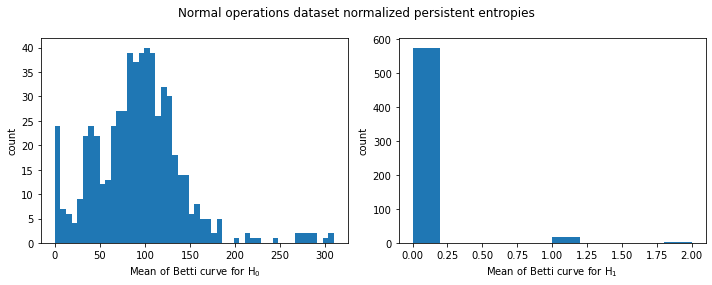

In [229]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))

stats_entropy.suptitle('Normal operations dataset normalized persistent entropies')

data[0].set_xlabel('Mean of Betti curve for H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Mean of Betti curve for H$_1$")
data[1].set_ylabel('count')

data[0].hist(meanBettiH0, bins=50)
data[1].hist(meanBettiH1)

plt.tight_layout()

In [162]:
meanBettiH1 = []
medianBettiH1 = []
modeBettiH1 = []

for i in range(len(normal_Betti[:,1,0])):
    meanBettiH1.append(stats.mean(normal_Betti[i,1,:]))
    medianBettiH1.append(stats.median(normal_Betti[i,1,:]))
    modeBettiH1.append(stats.mode(normal_Betti[i,1,:]))
    
    
figBetti = px.line()
figBetti.add_scatter(y=(meanBettiH1), name="Mean of Betti curve H_1")
figBetti.add_scatter(y=(medianBettiH1), name="Median of Betti curve H_1")
figBetti.show()


In [153]:
pers_H1 = []
pers_H0 = []
max_pers_H0 = []
max_pers_H1 = []

for PersDiag in normal_diagrams: 
    for point in PersDiag:
        birth = point[0]
        death = point[1]
        dimension = point[2]
        persistence = abs(death - birth)
        pers_H0.extend([persistence] if dimension == 0 else [])
        pers_H1.extend([persistence] if dimension == 1 else [])
    max_pers_H0.append(np.amax(pers_H0))
    max_pers_H1.append(np.amax(pers_H1))
    pers_H0 = []
    pers_H1 = []
           
fig = px.line(title='Maximum Persistence for normal BHP')
fig.add_scatter(y=max_pers_H1, name="Max Pers in homology dimension H_1")
fig.add_scatter(y=max_pers_H0, name="Max Pers in homology dimension H_0")

fig.show() 

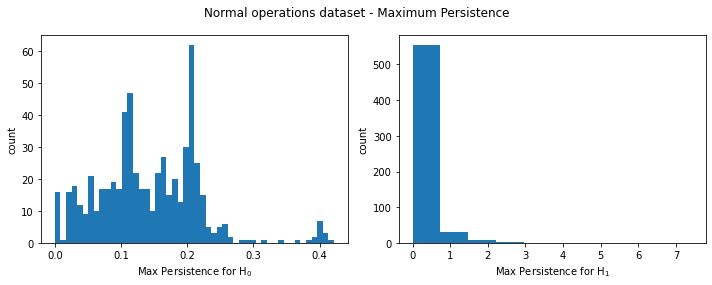

In [231]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))

stats_entropy.suptitle('Normal operations dataset - Maximum Persistence')

data[0].set_xlabel('Max Persistence for H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Max Persistence for H$_1$")
data[1].set_ylabel('count')

data[0].hist(max_pers_H0, bins=50)
data[1].hist(max_pers_H1)

plt.tight_layout()

## Analysis of Slugging P - TPT

In [131]:
slug_data_single_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/WELL-00001_20170320130025.csv")
signal = slug_data_single_df["P-TPT"]

In [132]:
optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=optimal_embedding_dimension, time_delay=optimal_time_delay, dimension=6, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 90
Optimal embedding dimension based on false nearest neighbors: 14


In [224]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/", "P-TPT")

12999

In [228]:
slugging_signals, slugging_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/REAL/", "P-TPT",3000)

0 WELL-00014_20170921200114.csv
1 WELL-00014_20170925160218.csv
2 WELL-00014_20170926170228.csv
3 WELL-00014_20170920010042.csv
4 WELL-00014_20170920060228.csv
5 WELL-00014_20170921050404.csv
6 WELL-00014_20170921100155.csv
7 WELL-00001_20170320130025.csv
8 WELL-00014_20170920110053.csv
9 WELL-00014_20170922060124.csv
10 WELL-00014_20170926020340.csv
11 WELL-00014_20171028130000.csv
12 WELL-00014_20170925210042.csv
13 WELL-00014_20171028080000.csv
14 WELL-00014_20170921000053.csv
15 WELL-00014_20170919210016.csv
16 WELL-00014_20170925060042.csv
17 WELL-00014_20171028180038.csv
18 WELL-00014_20170920190207.csv
19 WELL-00014_20170925010031.csv
20 WELL-00014_20170918020114.csv
21 WELL-00014_20170917200000.csv
22 WELL-00014_20170926070042.csv
23 WELL-00014_20170922010042.csv
24 WELL-00014_20170922110042.csv
25 WELL-00014_20170918120103.csv
26 WELL-00014_20170921150042.csv
27 WELL-00014_20170926120103.csv
28 WELL-00014_20170918070135.csv
29 WELL-00014_20170922160249.csv
30 WELL-00014_201709

In [229]:
slugging_df

0           1           2           3           4           5   \
0     15923800.0  16364360.0  14545720.0  15763660.0  14563290.0  16229530.0   
1     15918610.0  16363720.0  14548790.0  15765810.0  14576340.0  16229990.0   
2     15912720.0  16362380.0  14551830.0  15765690.0  14590570.0  16229360.0   
3     15907210.0  16362290.0  14555280.0  15767940.0  14601440.0  16229920.0   
4     15897370.0  16363950.0  14559050.0  15772310.0  14607750.0  16230600.0   
...          ...         ...         ...         ...         ...         ...   
3514  15601080.0  16158280.0  13981860.0  13736930.0  16264270.0  15348450.0   
3515  15605130.0  16157700.0  13979980.0  13742360.0  16263460.0  15354840.0   
3516  15608310.0  16156370.0  13979130.0  13746210.0  16263780.0  15356840.0   
3517  15613390.0  16155690.0  13976880.0  13750370.0  16260680.0  15361840.0   
3518  15618110.0  16153770.0  13975350.0  13754140.0  16258560.0  15368150.0   

              6           7           8           9   ...          22  \
0     15593270.0  14071870.0  15840130.0  14177770.0  ...  13829370.0   
1     15595580.0  14073420.0  15828820.0  14182160.0  ...  13835010.0   
2     15599700.0  14074970.0  15817510.0  14185840.0  ...  13841950.0   
3     15603820.0  14076510.0  15807980.0  14189210.0  ...  13848500.0   
4     15606990.0  14078060.0  15790800.0  14194490.0  ...  13854790.0   
...          ...         ...         ...         ...  ...         ...   
3514  13590550.0  14229030.0  12149200.0  16302390.0  ...  15017960.0   
3515  13596640.0  14227370.0  12161210.0  16301330.0  ...  15021780.0   
3516  13603510.0  14225710.0  12166690.0  16301920.0  ...  15032080.0   
3517  13610120.0  14224050.0  12173620.0  16301910.0  ...  15040110.0   
3518  13617340.0  14220720.0  12182160.0  16301760.0  ...  15046450.0   

              23          24          25          26          27          28  \
0     15829460.0  16268030.0  14860340.0  14000140.0  15411580.0  14999240.0   
1     15831490.0  16265920.0  14865070.0  14002940.0  15416880.0  15002700.0   
2     15835000.0  16263820.0  14871360.0  14008580.0  15420080.0  15006930.0   
3     15837910.0  16262160.0  14876400.0  14010840.0  15423520.0  15010630.0   
4     15840540.0  16260860.0  14880480.0  14015900.0  15426060.0  15013240.0   
...          ...         ...         ...         ...         ...         ...   
3514  13505350.0  15501240.0  15517070.0  16151040.0  14030170.0  14368110.0   
3515  13514340.0  15507060.0  15522500.0  16146620.0  14036000.0  14376500.0   
3516  13526300.0  15511520.0  15525430.0  16144820.0  14040760.0  14382870.0   
3517  13535350.0  15517210.0  15530240.0  16144140.0  14045990.0  14390450.0   
3518  13542800.0  15521980.0  15534560.0  16141870.0  14051040.0  14395950.0   

              29          30          31  
0     15915160.0  14880540.0  13445530.0  
1     15916140.0  14883960.0  13444940.0  
2     15917620.0  14894200.0  13444910.0  
3     15921260.0  14901340.0  13445490.0  
4     15924210.0  14907540.0  13445100.0  
...          ...         ...         ...  
3514  14270350.0  16648820.0  13891160.0  
3515  14271750.0  16646380.0  13891950.0  
3516  14273620.0  16643070.0  13893790.0  
3517  14275360.0  16639880.0  13895500.0  
3518  14278320.0  16633380.0  13897590.0  

[3519 rows x 32 columns]

Convert everything to Bar to get better resolution in the filtration (otherwise the Betti curves are unreadable)

In [230]:
PatoBar = 1/100000

slugging_df = slugging_df.apply(lambda x: x*PatoBar)
slugging_df 

0         1         2         3         4         5         6   \
0     159.2380  163.6436  145.4572  157.6366  145.6329  162.2953  155.9327   
1     159.1861  163.6372  145.4879  157.6581  145.7634  162.2999  155.9558   
2     159.1272  163.6238  145.5183  157.6569  145.9057  162.2936  155.9970   
3     159.0721  163.6229  145.5528  157.6794  146.0144  162.2992  156.0382   
4     158.9737  163.6395  145.5905  157.7231  146.0775  162.3060  156.0699   
...        ...       ...       ...       ...       ...       ...       ...   
3514  156.0108  161.5828  139.8186  137.3693  162.6427  153.4845  135.9055   
3515  156.0513  161.5770  139.7998  137.4236  162.6346  153.5484  135.9664   
3516  156.0831  161.5637  139.7913  137.4621  162.6378  153.5684  136.0351   
3517  156.1339  161.5569  139.7688  137.5037  162.6068  153.6184  136.1012   
3518  156.1811  161.5377  139.7535  137.5414  162.5856  153.6815  136.1734   

            7         8         9   ...        22        23        24  \
0     140.7187  158.4013  141.7777  ...  138.2937  158.2946  162.6803   
1     140.7342  158.2882  141.8216  ...  138.3501  158.3149  162.6592   
2     140.7497  158.1751  141.8584  ...  138.4195  158.3500  162.6382   
3     140.7651  158.0798  141.8921  ...  138.4850  158.3791  162.6216   
4     140.7806  157.9080  141.9449  ...  138.5479  158.4054  162.6086   
...        ...       ...       ...  ...       ...       ...       ...   
3514  142.2903  121.4920  163.0239  ...  150.1796  135.0535  155.0124   
3515  142.2737  121.6121  163.0133  ...  150.2178  135.1434  155.0706   
3516  142.2571  121.6669  163.0192  ...  150.3208  135.2630  155.1152   
3517  142.2405  121.7362  163.0191  ...  150.4011  135.3535  155.1721   
3518  142.2072  121.8216  163.0176  ...  150.4645  135.4280  155.2198   

            25        26        27        28        29        30        31  
0     148.6034  140.0014  154.1158  149.9924  159.1516  148.8054  134.4553  
1     148.6507  140.0294  154.1688  150.0270  159.1614  148.8396  134.4494  
2     148.7136  140.0858  154.2008  150.0693  159.1762  148.9420  134.4491  
3     148.7640  140.1084  154.2352  150.1063  159.2126  149.0134  134.4549  
4     148.8048  140.1590  154.2606  150.1324  159.2421  149.0754  134.4510  
...        ...       ...       ...       ...       ...       ...       ...  
3514  155.1707  161.5104  140.3017  143.6811  142.7035  166.4882  138.9116  
3515  155.2250  161.4662  140.3600  143.7650  142.7175  166.4638  138.9195  
3516  155.2543  161.4482  140.4076  143.8287  142.7362  166.4307  138.9379  
3517  155.3024  161.4414  140.4599  143.9045  142.7536  166.3988  138.9550  
3518  155.3456  161.4187  140.5104  143.9595  142.7832  166.3338  138.9759  

[3519 rows x 32 columns]

In [232]:
slug_point_clouds_pca, slug_diagrams, slug_entropies, slug_norm_entropies = batch_analyzer(slugging_df, 3, 12, 150)

analyzing nr. 1 progress: 3 % dim 7 delay 149
analyzing nr. 2 progress: 6 % dim 7 delay 139
analyzing nr. 3 progress: 9 % dim 7 delay 137
analyzing nr. 4 progress: 12 % dim 7 delay 142
analyzing nr. 5 progress: 15 % dim 7 delay 148
analyzing nr. 6 progress: 18 % dim 4 delay 150
analyzing nr. 7 progress: 21 % dim 7 delay 148
analyzing nr. 8 progress: 25 % dim 8 delay 117
analyzing nr. 9 progress: 28 % dim 4 delay 141
analyzing nr. 10 progress: 31 % dim 7 delay 150
analyzing nr. 11 progress: 34 % dim 6 delay 147
analyzing nr. 12 progress: 37 % dim 7 delay 150
analyzing nr. 13 progress: 40 % dim 7 delay 142
analyzing nr. 14 progress: 43 % dim 8 delay 127
analyzing nr. 15 progress: 46 % dim 7 delay 147
analyzing nr. 16 progress: 50 % dim 6 delay 149
analyzing nr. 17 progress: 53 % dim 7 delay 150
analyzing nr. 18 progress: 56 % dim 7 delay 148
analyzing nr. 19 progress: 59 % dim 7 delay 142
analyzing nr. 20 progress: 62 % dim 7 delay 148
analyzing nr. 21 progress: 65 % dim 5 delay 150
anal

In [233]:
tmp = slug_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

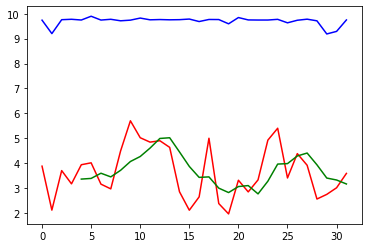

In [234]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [235]:
tmp = slug_norm_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

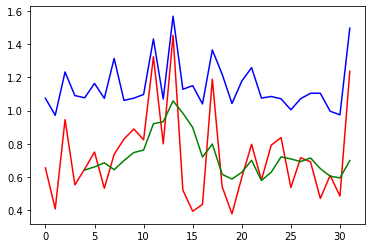

In [236]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [237]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED/", "P-TPT")

12999

In [238]:
slugging_signals, slugging_SIM_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED/", "P-TPT",3000)
slugging_df = slugging_df.apply(lambda x: x*PatoBar)

0 SIMULATED_00035.csv
1 SIMULATED_00021.csv
2 SIMULATED_00009.csv
3 SIMULATED_00008.csv
4 SIMULATED_00020.csv
5 SIMULATED_00034.csv
6 SIMULATED_00022.csv
7 SIMULATED_00036.csv
8 SIMULATED_00037.csv
9 SIMULATED_00023.csv
10 SIMULATED_00027.csv
11 SIMULATED_00033.csv
12 SIMULATED_00032.csv
13 SIMULATED_00026.csv
14 SIMULATED_00018.csv
15 SIMULATED_00030.csv
16 SIMULATED_00024.csv
17 SIMULATED_00025.csv
18 SIMULATED_00031.csv
19 SIMULATED_00019.csv
20 SIMULATED_00056.csv
21 SIMULATED_00042.csv
22 SIMULATED_00043.csv
23 SIMULATED_00057.csv
24 SIMULATED_00041.csv
25 SIMULATED_00055.csv
26 SIMULATED_00069.csv
27 SIMULATED_00068.csv
28 SIMULATED_00054.csv
29 SIMULATED_00040.csv
30 SIMULATED_00044.csv
31 SIMULATED_00050.csv
32 SIMULATED_00051.csv
33 SIMULATED_00045.csv
34 SIMULATED_00053.csv
35 SIMULATED_00047.csv
36 SIMULATED_00046.csv
37 SIMULATED_00052.csv
38 SIMULATED_00063.csv
39 SIMULATED_00062.csv
40 SIMULATED_00060.csv
41 SIMULATED_00074.csv
42 SIMULATED_00048.csv
43 SIMULATED_00049.cs

In [239]:
slugSIM_point_clouds_pca, slugSIM_diagrams, slugSIM_entropies, slugSIM_norm_entropies = batch_analyzer(slugging_SIM_df, 2, 20, 90)

analyzing nr. 1 progress: 1 % dim 12 delay 89
analyzing nr. 2 progress: 2 % dim 13 delay 76
analyzing nr. 3 progress: 4 % dim 12 delay 89
analyzing nr. 4 progress: 5 % dim 11 delay 90
analyzing nr. 5 progress: 6 % dim 12 delay 89
analyzing nr. 6 progress: 8 % dim 11 delay 90
analyzing nr. 7 progress: 9 % dim 12 delay 88
analyzing nr. 8 progress: 10 % dim 12 delay 90
analyzing nr. 9 progress: 12 % dim 12 delay 88
analyzing nr. 10 progress: 13 % dim 9 delay 89
analyzing nr. 11 progress: 14 % dim 12 delay 87
analyzing nr. 12 progress: 16 % dim 13 delay 82
analyzing nr. 13 progress: 17 % dim 8 delay 63
analyzing nr. 14 progress: 18 % dim 12 delay 90
analyzing nr. 15 progress: 20 % dim 12 delay 90
analyzing nr. 16 progress: 21 % dim 11 delay 90
analyzing nr. 17 progress: 22 % dim 9 delay 90
analyzing nr. 18 progress: 24 % dim 12 delay 79
analyzing nr. 19 progress: 25 % dim 13 delay 85
analyzing nr. 20 progress: 27 % dim 10 delay 90
analyzing nr. 21 progress: 28 % dim 14 delay 74
analyzing n

In [240]:
tmp = slugSIM_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

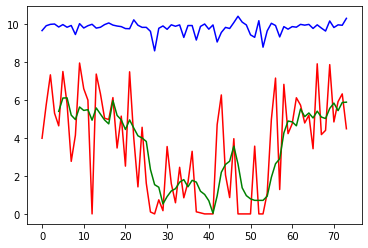

In [241]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [242]:
tmp = slugSIM_norm_entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H0_slug = pd.Series(Entropy_H0)
Entropy_H1_slug = pd.Series(Entropy_H1)

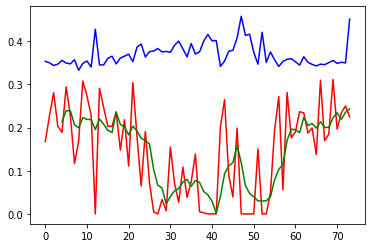

In [243]:
plt.plot(Entropy_H0_slug, 'b-')
plt.plot(Entropy_H1_slug, 'r-')
plt.plot(Entropy_H1_slug.rolling(5).mean(), 'g-')

In [244]:
slugging_signals, slugging_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/", "P-TPT",3000)
slugging_df = slugging_df.apply(lambda x: x*PatoBar)

0 SIMULATED_00035.csv
1 SIMULATED_00021.csv
2 SIMULATED_00009.csv
3 WELL-00014_20170921200114.csv
4 WELL-00014_20170925160218.csv
5 WELL-00014_20170926170228.csv
6 SIMULATED_00008.csv
7 SIMULATED_00020.csv
8 SIMULATED_00034.csv
9 SIMULATED_00022.csv
10 WELL-00014_20170920010042.csv
11 SIMULATED_00036.csv
12 WELL-00014_20170920060228.csv
13 WELL-00014_20170921050404.csv
14 SIMULATED_00037.csv
15 SIMULATED_00023.csv
16 WELL-00014_20170921100155.csv
17 SIMULATED_00027.csv
18 WELL-00001_20170320130025.csv
19 WELL-00014_20170920110053.csv
20 SIMULATED_00033.csv
21 WELL-00014_20170922060124.csv
22 SIMULATED_00032.csv
23 SIMULATED_00026.csv
24 SIMULATED_00018.csv
25 SIMULATED_00030.csv
26 SIMULATED_00024.csv
27 WELL-00014_20170926020340.csv
28 WELL-00014_20171028130000.csv
29 SIMULATED_00025.csv
30 SIMULATED_00031.csv
31 SIMULATED_00019.csv
32 SIMULATED_00056.csv
33 SIMULATED_00042.csv
34 WELL-00014_20170925210042.csv
35 WELL-00014_20171028080000.csv
36 SIMULATED_00043.csv
37 SIMULATED_00057.

In [245]:
slug_point_clouds_pca, slug_diagrams, slug_entropies, slug_norm_entropies = batch_analyzer(slugging_df, 2, 12, 150)

analyzing nr. 1 progress: 0 % dim 10 delay 111
analyzing nr. 2 progress: 1 % dim 8 delay 150
analyzing nr. 3 progress: 2 % dim 7 delay 149
analyzing nr. 4 progress: 3 % dim 7 delay 149
analyzing nr. 5 progress: 4 % dim 8 delay 139
analyzing nr. 6 progress: 5 % dim 7 delay 147
analyzing nr. 7 progress: 6 % dim 8 delay 127
analyzing nr. 8 progress: 7 % dim 8 delay 142
analyzing nr. 9 progress: 8 % dim 8 delay 136
analyzing nr. 10 progress: 9 % dim 8 delay 150
analyzing nr. 11 progress: 10 % dim 7 delay 145
analyzing nr. 12 progress: 11 % dim 8 delay 150
analyzing nr. 13 progress: 12 % dim 7 delay 146
analyzing nr. 14 progress: 13 % dim 8 delay 150
analyzing nr. 15 progress: 14 % dim 8 delay 149
analyzing nr. 16 progress: 15 % dim 8 delay 140
analyzing nr. 17 progress: 16 % dim 7 delay 138
analyzing nr. 18 progress: 16 % dim 12 delay 87
analyzing nr. 19 progress: 17 % dim 8 delay 140
analyzing nr. 20 progress: 18 % dim 8 delay 141
analyzing nr. 21 progress: 19 % dim 10 delay 112
analyzing

In [295]:
slug_data = read_files_bundle("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/", "P-TPT",3000)
slug_data = slug_data * PatoBar

VRP_onlyH0 = VietorisRipsPersistence(homology_dimensions =(0,))
VRP_onlyH1 = VietorisRipsPersistence(homology_dimensions =(1,))

TE = TakensEmbedding(time_delay=145, dimension=8, stride=2)
slug_data_norm = TE.fit_transform(slug_data)
slug_data_diagrams_norm = VRP.fit_transform(slug_data_norm)
slug_data_diagrams_H0 = VRP_onlyH0.fit_transform(slug_data_norm)
slug_data_diagrams_H1 = VRP_onlyH1.fit_transform(slug_data_norm)
slug_data_Betti_H0 = Betti.fit_transform(slug_data_diagrams_H0)
slug_data_Betti_H1 = Betti.fit_transform(slug_data_diagrams_H1)

Let's see the results for a simulated slugging event, sample nr.60

In [296]:
TE.fit_transform_plot(slug_data, sample=60)

array([[[92.24574, 99.02855, 91.01058, ..., 94.38902, 84.83733,
         97.93617],
        [93.72865, 98.84169, 89.2601 , ..., 93.21072, 86.24782,
         98.48981],
        [95.06738, 98.53024, 87.00533, ..., 91.63011, 87.83656,
         98.86081],
        ...,
        [98.83236, 94.87591, 84.25333, ..., 83.36549, 95.18877,
         98.50093],
        [99.04101, 93.80179, 85.5164 , ..., 83.26283, 96.36263,
         98.02386],
        [99.08989, 92.41351, 87.03487, ..., 83.88073, 97.31574,
         97.37884]]])

In [297]:
VRP.fit_transform_plot(slug_data_norm, sample=60)

array([[[0.00000000e+00, 1.32532865e-02, 0.00000000e+00],
        [0.00000000e+00, 1.68437790e-02, 0.00000000e+00],
        [0.00000000e+00, 1.71280764e-02, 0.00000000e+00],
        ...,
        [0.00000000e+00, 2.45741874e-01, 0.00000000e+00],
        [0.00000000e+00, 2.46027678e-01, 0.00000000e+00],
        [2.51665086e-01, 2.35376129e+01, 1.00000000e+00]]])

In [298]:
sample60_H0 = VRP_onlyH0.fit_transform_plot(slug_data_norm, sample=60)

In [316]:
slug_data_diagrams_H0[60]

array([[0.        , 0.01325329, 0.        ],
       [0.        , 0.01684378, 0.        ],
       [0.        , 0.01712808, 0.        ],
       ...,
       [0.        , 0.24568807, 0.        ],
       [0.        , 0.24574187, 0.        ],
       [0.        , 0.24602768, 0.        ]])

In [328]:
slug_data_Betti_H1[60]

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [337]:
VRP_onlyH0.fit_transform_plot(slug_data_norm, sample=4)

array([[[ 0.        ,  0.19112226,  0.        ],
        [ 0.        ,  0.21258111,  0.        ],
        [ 0.        ,  0.22174799,  0.        ],
        ...,
        [ 0.        , 17.25113106,  0.        ],
        [ 0.        , 18.42709541,  0.        ],
        [ 0.        , 19.88757133,  0.        ]]])

In [326]:
Betti.fit_transform_plot(slug_data_diagrams_H0, sample=60)

array([[[1014,   88,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]])

In [303]:
slug_data_single_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/SIMULATED_00062.csv")
signal = slug_data_single_df["P-TPT"]
signal = signal / 100000

max_time_delay = 180
max_embedding_dimension = 12
stride = 1

ratio = len(signal)/1500
signal = signal[::int(ratio)]

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )
print(f"signal lenght: {len(signal)}")
print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay


embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)
diagram = VRP.fit_transform_plot(signal_embedded_pca[None,:,:])
Betti.fit_transform_plot(diagram)



signal lenght: 1513
Optimal embedding time delay based on mutual information: 82
Optimal embedding dimension based on false nearest neighbors: 10


array([[[774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774,
         774, 773, 767, 761, 748, 742, 734, 719, 708, 695, 685, 677,
         660, 647, 633, 621, 607, 597, 574, 559, 552, 538, 526, 513,
         502, 492, 483, 473, 455, 438, 428, 417, 412, 398, 385, 377,
         370, 354, 340, 326, 315, 302, 288, 274, 261, 253, 239, 227,
         216, 208, 191, 183, 175, 162, 147, 139, 134, 124, 116, 109,
         104,  96,  92,  90,  88,  84,  81,  77,  70,  68,  64,  58,
          56,  55,  52,  50,  48,  40,  35,  31,  26,  23,  19,  12,
          10,   7,   2,   0],
        [  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
    

Let's see sample nr.64 (non simulated)

In [334]:
TE.fit_transform_plot(slug_data, sample=4)

array([[[163.6436, 158.66  , 137.5177, ..., 158.1651, 163.5737,
         159.1512],
        [163.6238, 158.5318, 137.4326, ..., 158.2577, 163.6978,
         158.9119],
        [163.6395, 158.336 , 137.3838, ..., 158.3854, 163.8127,
         158.5804],
        ...,
        [136.5257, 142.7383, 148.8093, ..., 153.5653, 135.9049,
         143.0031],
        [136.5236, 142.8635, 148.8948, ..., 153.2994, 135.952 ,
         143.125 ],
        [136.5214, 143.0203, 149.    , ..., 152.961 , 136.0115,
         143.2905]]])

In [335]:
VRP.fit_transform_plot(slug_data_norm, sample=4)

array([[[ 0.        ,  0.19112226,  0.        ],
        [ 0.        ,  0.21258111,  0.        ],
        [ 0.        ,  0.22174799,  0.        ],
        ...,
        [15.61036682, 34.86309814,  1.        ],
        [12.68916321, 12.72562122,  1.        ],
        [12.65943336, 12.69952297,  1.        ]]])

In [333]:
figBettiSlug0 = px.line()

#for i in range(len(slug_data_Betti_H0[:,0,0])):
for i in range(20):
    figBettiSlug0.add_scatter(y=(slug_data_Betti_H0[i, 0, :]+50*i))
figBettiSlug0.show()

In [306]:
figBettiSlug1 = px.line()

for i in range(len(slug_data_Betti_H1[:,0,0])):
    figBettiSlug1.add_scatter(y=(slug_data_Betti_H1[i, 0, :]+5*i))
figBettiSlug1.show()

In [308]:
meanBettiH0 = []
medianBettiH0 = []
modeBettiH0 = []
maxBettiH0 = []
meanBettiH1 = []
medianBettiH1 = []
modeBettiH1 = []
maxBettiH1 = []

for i in range(len(slug_data_Betti_H0[:,0,0])):
    meanBettiH0.append(stats.mean(slug_data_Betti_H0[i,0,:]))
    medianBettiH0.append(stats.median(slug_data_Betti_H0[i,0,:]))
    modeBettiH0.append(stats.mode(slug_data_Betti_H0[i,0,:]))
    maxBettiH0.append(np.amax(slug_data_Betti_H0[i,0,:]))
    
for i in range(len(slug_data_Betti_H1[:,0,0])):
    meanBettiH1.append(stats.mean(slug_data_Betti_H1[i,0,:]))
    medianBettiH1.append(stats.median(slug_data_Betti_H1[i,0,:]))
    modeBettiH1.append(stats.mode(slug_data_Betti_H1[i,0,:]))
    maxBettiH1.append(np.amax(slug_data_Betti_H1[i,0,:]))
    
    
figBettiH0 = px.line()
figBettiH0.add_scatter(y=(meanBettiH0), name="Mean of Betti curve H_0")
figBettiH0.add_scatter(y=(medianBettiH0), name="Median of Betti curve H_0")
figBettiH0.add_scatter(y=(modeBettiH0),name="Mode of Betti curve H_0")
#figBetti.add_scatter(y=(maxBettiH0),name="Max of Betti curve H_0")
figBettiH0.show()

In [309]:
figBettiH1 = px.line()
figBettiH1.add_scatter(y=(meanBettiH1), name="Mean of Betti curve H_1")
figBettiH1.add_scatter(y=(medianBettiH1), name="Median of Betti curve H_1")
figBettiH1.add_scatter(y=(modeBettiH1),name="Mode of Betti curve H_1")
#figBetti.add_scatter(y=(maxBettiH1),name="Max of Betti curve H_1")

figBettiH1.show()

In [341]:
slug_data_Betti_H0[2]

array([[1014, 1014, 1014, 1014,  992,  950,  905,  868,  832,  803,  767,
         730,  705,  677,  651,  625,  598,  569,  531,  492,  458,  426,
         395,  355,  312,  273,  243,  209,  178,  149,  121,   98,   81,
          67,   54,   42,   28,   23,   18,   13,   10,    9,    9,    6,
           3,    2,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [342]:
maxBettiH0 =[]
maxBettiH1 =[]

for i in range(len(slug_data_Betti_H0[:,0,0])):
    maxBettiH0.append(np.amax(slug_data_Betti_H0[i,0,:]))
for i in range(len(slug_data_Betti_H1[:,0,0])):
    maxBettiH1.append(np.amax(slug_data_Betti_H1[i,0,:]))
        
figBetti = px.line()
#figBetti.add_scatter(y=(maxBettiH0),name="Max of Betti curve H_0")
figBetti.add_scatter(y=(maxBettiH1),name="Max of Betti curve H_1")

figBetti.show()

In [330]:
pers_H0 = []
pers_H1 = []
max_pers_H0 = []
max_pers_H1 = []

for PersDiag in slug_data_diagrams_norm: 
    for point in PersDiag:
        birth = point[0]
        death = point[1]
        dimension = point[2]
        persistence = abs(death - birth)
        pers_H0.extend([persistence] if dimension == 0 else [])
        pers_H1.extend([persistence] if dimension == 1 else [])
    max_pers_H0.append(np.amax(pers_H0))
    max_pers_H1.append(np.amax(pers_H1))
    pers_H0 = []
    pers_H1 = []
           
fig = px.line(title='Maximum Persistence for BHP, slugging dataset')
fig.add_scatter(y=max_pers_H0, name="Max Pers in homology dimension H_0")
fig.add_scatter(y=max_pers_H1, name="Max Pers in homology dimension H_1")
fig.show() 

In [223]:
slug_data_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED_00005.csv")

In [224]:
slug_data_df

timestamp       P-PDG       P-TPT     T-TPT  \
0      2018-04-08 03:23:38.000000  26201590.0  16807680.0  118.3466   
1      2018-04-08 03:23:39.000000  26201410.0  16807450.0  118.3465   
2      2018-04-08 03:23:40.000000  26201220.0  16807220.0  118.3464   
3      2018-04-08 03:23:41.000000  26201030.0  16806980.0  118.3462   
4      2018-04-08 03:23:42.000000  26200840.0  16806750.0  118.3461   
...                           ...         ...         ...       ...   
61994  2018-04-08 20:36:52.000000  26910280.0  17541780.0  112.9325   
61995  2018-04-08 20:36:53.000000  26910300.0  17541870.0  112.9322   
61996  2018-04-08 20:36:54.000000  26910310.0  17541950.0  112.9320   
61997  2018-04-08 20:36:55.000000  26910330.0  17542030.0  112.9317   
61998  2018-04-08 20:36:56.000000  26910350.0  17542110.0  112.9314   

       P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0      4047800.0   83.66679         NaN         NaN  NaN      3  
1      4047815.0   83.66234         NaN         NaN  NaN      3  
2      4047830.0   83.65790         NaN         NaN  NaN      3  
3      4047843.0   83.65346         NaN         NaN  NaN      3  
4      4047856.0   83.64903         NaN         NaN  NaN      3  
...          ...        ...         ...         ...  ...    ...  
61994  4051613.0   49.87471         NaN         NaN  NaN      3  
61995  4051594.0   49.87138         NaN         NaN  NaN      3  
61996  4051575.0   49.86807         NaN         NaN  NaN      3  
61997  4051555.0   49.86476         NaN         NaN  NaN      3  
61998  4051536.0   49.86146         NaN         NaN  NaN      3  

[61999 rows x 10 columns]

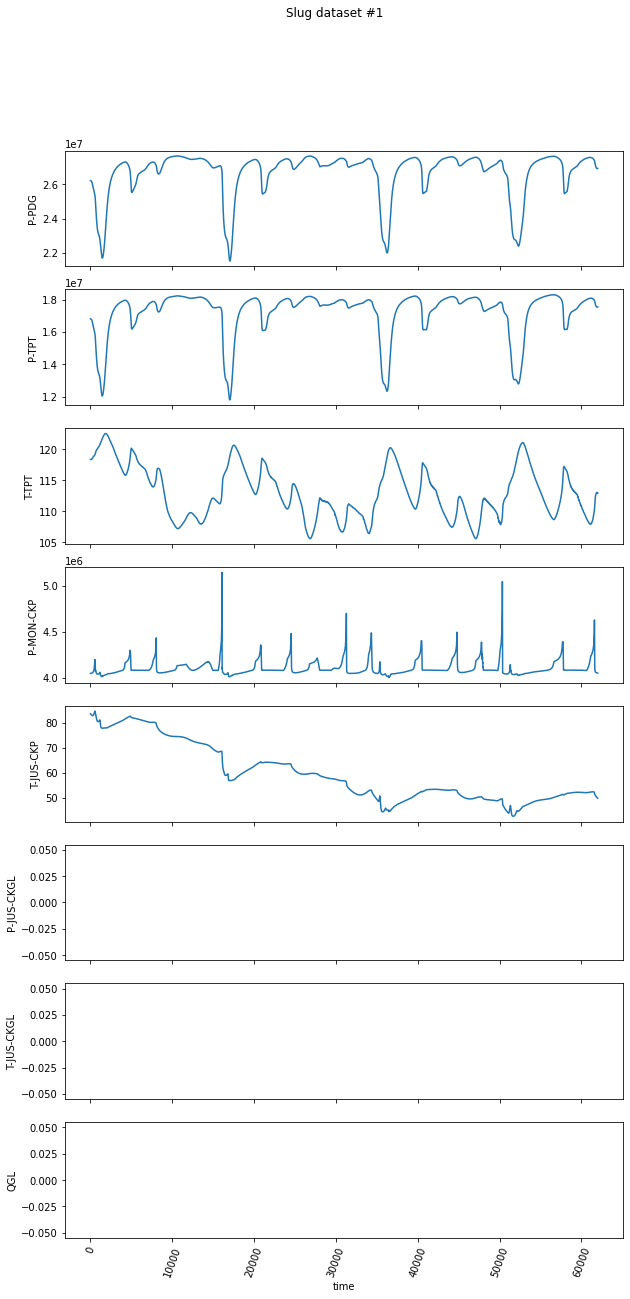

In [225]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_df.index, slug_data_df["P-PDG"])
ts[1].plot(slug_data_df.index, slug_data_df["P-TPT"])
ts[2].plot(slug_data_df.index, slug_data_df["T-TPT"])
ts[3].plot(slug_data_df.index, slug_data_df["P-MON-CKP"])
ts[4].plot(slug_data_df.index, slug_data_df["T-JUS-CKP"])
ts[5].plot(slug_data_df.index, slug_data_df["P-JUS-CKGL"])
ts[6].plot(slug_data_df.index, slug_data_df["T-JUS-CKGL"])
ts[7].plot(slug_data_df.index, slug_data_df["QGL"])


In [226]:
slug_data_df['P-TPT'].isnull().values.any()

False

In [227]:
slug_data_df= slug_data_df.interpolate()

In [233]:
period = 50
periodicSampler = Resampler(period=period)
slug_data_df = slug_data_df.interpolate(method='linear')
signal = slug_data_df["P-TPT"]

#slug_data_df.index, slug_data_df["P-TPT"]
index_sampled, signal_sampled = periodicSampler.fit_transform_resample(slug_data_df.index, signal)

#print(index_sampled, signal_sampled, len(signal_sampled))

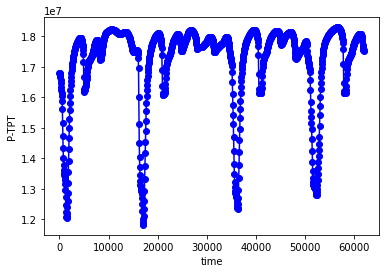

In [234]:
signal_downsampled = pd.DataFrame(signal_sampled,
                  index=index_sampled, columns=['P-TPT'])
#signal_downsampled['P-TPT']
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_downsampled.index,signal_downsampled['P-TPT'], 'bo-')

In [236]:
print('length of signal to analyze', len(signal_downsampled))

max_time_delay = 150 
max_embedding_dimension = 15
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal_downsampled)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

length of signal to analyze 1240
Optimal embedding time delay based on mutual information: 58
Optimal embedding dimension based on false nearest neighbors: 11


In [237]:
homology_dimensions = (0, 1)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

signal_embedded_reshaped = signal_embedded.reshape(1, *signal_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_embedded.shape)

PerHom_signal = VRP.fit_transform(signal_embedded_reshaped)
VRP.plot(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 660, 11)
y_wn_embedded.shape (660, 11)


In [238]:
PE_slug = PersistenceEntropy()
PE_slug_norm = PersistenceEntropy(normalize=True)
features = PE_slug.fit_transform(PerHom_signal)
features_norm = PE_slug_norm.fit_transform(PerHom_signal)

In [239]:
features

array([[9.14272792, 4.02067644]])

In [240]:
features_norm

array([[0.33100592, 0.1620816 ]])

In [265]:
slug_data_sim_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/8/WELL-00021_20170509013517.csv")

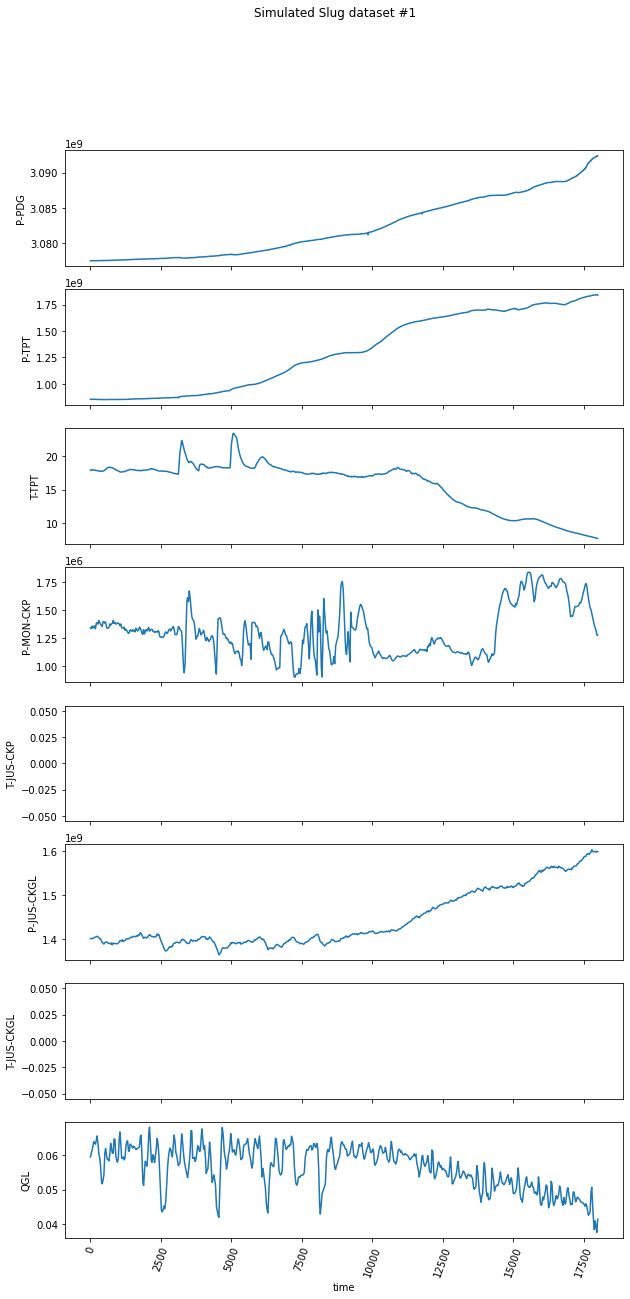

In [266]:
slug_data_sim_df = slug_data_sim_df.head(18000)

fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Simulated Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_sim_df.index, slug_data_sim_df["P-PDG"])
ts[1].plot(slug_data_sim_df.index, slug_data_sim_df["P-TPT"])
ts[2].plot(slug_data_sim_df.index, slug_data_sim_df["T-TPT"])
ts[3].plot(slug_data_sim_df.index, slug_data_sim_df["P-MON-CKP"])
ts[4].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKP"])
ts[5].plot(slug_data_sim_df.index, slug_data_sim_df["P-JUS-CKGL"])
ts[6].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKGL"])
ts[7].plot(slug_data_sim_df.index, slug_data_sim_df["QGL"])


In [253]:
period = 5
periodicSampler = Resampler(period=period)
signal = slug_data_sim_df["P-TPT"]

slug_data_sim_df.index, slug_data_sim_df["P-TPT"]
index_sampled, signal_sim_sampled = periodicSampler.fit_transform_resample(slug_data_sim_df.index, signal)


In [254]:
signal_sim_sampled

array([17747090., 17748130., 17749180., ..., 17782190., 17780100.,
       17776750.])

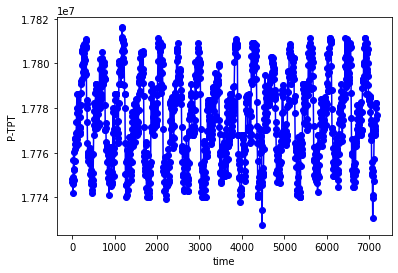

In [255]:
signal_sim_downsampled = pd.DataFrame(signal_sim_sampled,
                  index=index_sampled, columns=['P-TPT'])
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_sim_downsampled.index,signal_sim_downsampled['P-TPT'], 'bo-')

In [256]:
print('length of signal to analyze', len(signal_sim_downsampled))

max_time_delay = 50 
max_embedding_dimension = 10
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_sim_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_sim_embedded = embedder.fit_transform(signal_sim_downsampled)

pca = PCA(n_components=3)
signal_sim_embedded_pca = pca.fit_transform(signal_sim_embedded)

plot_point_cloud(signal_sim_embedded_pca)

length of signal to analyze 1436
Optimal embedding time delay based on mutual information: 16
Optimal embedding dimension based on false nearest neighbors: 9


In [257]:
signal_sim_embedded_reshaped = signal_sim_embedded.reshape(1, *signal_sim_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_sim_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_sim_embedded_reshaped.shape)

PerHom_sim_signal = VRP.fit_transform(signal_sim_embedded_reshaped)
features_sim = PE_slug.fit_transform(PerHom_signal)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 1308, 9)
y_wn_embedded.shape (1, 1308, 9)


In [258]:
features_sim

array([[9.14272792, 4.02067644]])

In [259]:
features_sim_norm

array([[0.33100592, 0.1620816 ]])

In [260]:
VRP.plot(PerHom_sim_signal)

In [82]:
PerHom_sim_signal.shape

(1, 919, 3)

In [89]:
PerHom_signal.shape

#tmp = np.vstack([PerHom_signal,PerHom_sim_signal])
#tmp.shape

(1, 533, 3)

In [94]:
diagramScaler = Scaler()
PerHom_signal_scaled = diagramScaler.fit_transform(PerHom_signal)
diagramScaler.plot(PerHom_signal_scaled)

In [92]:
PerHom_signal_sim_scaled = diagramScaler.fit_transform(PerHom_sim_signal)
diagramScaler.plot(PerHom_signal_sim_scaled)

In [95]:
features_sim = PE_slug.fit_transform(PerHom_signal_scaled)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal_scaled)
features_sim

array([[8.85156327, 2.40306284, 4.83440879]])

In [96]:
features_sim_norm

array([[  1.49319727,   1.05423515, -11.44457834]])

In [111]:
HK = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1) 
HK_slug = HK.fit_transform_plot(PerHom_signal_scaled, homology_dimension_idx=1)

In [112]:
HK.fit_transform_plot(PerHom_signal_sim_scaled, homology_dimension_idx=1)

array([[[[ 5.07638691e+02,  4.99572666e+02,  4.91460183e+02, ...,
           1.66820580e+01,  8.32249323e+00,  0.00000000e+00],
         [ 5.00163881e+02,  4.92070493e+02,  4.83931025e+02, ...,
           8.36008392e+00,  0.00000000e+00, -8.32249323e+00],
         [ 4.92624107e+02,  4.84503736e+02,  4.76337670e+02, ...,
           0.00000000e+00, -8.36008392e+00, -1.66820580e+01],
         ...,
         [ 1.78456729e+01,  8.93264763e+00,  0.00000000e+00, ...,
          -4.76337670e+02, -4.83931025e+02, -4.91460183e+02],
         [ 8.91354577e+00,  0.00000000e+00, -8.93264763e+00, ...,
          -4.84503736e+02, -4.92070493e+02, -4.99572666e+02],
         [ 0.00000000e+00, -8.91354577e+00, -1.78456729e+01, ...,
          -4.92624107e+02, -5.00163881e+02, -5.07638691e+02]],

        [[ 6.89021565e+00,  6.71087491e+00,  6.20037748e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.07434908e+00,  6.89021565e+00,  6.36607574e+00, ...,
           0.00000000e